 This notebook file (\*.ipynb) was generated from the corresponding python file (\*.py).

 ## Attempt 01: 単純な音声の切り貼り

 変換先の音声が十分にあるなら、変換元の声の発音に近い変換先話者の音声を切り貼りするだけでもそれなりにうまく変換できるかもしれないと思ったので、試してみる。
 

In [1]:
import faiss
import numpy as np
import torch
from autofaiss import build_index
from tqdm import tqdm

from engine.lib.dataset_jvs import JVS
from engine.lib.extract import Wav2Vec2, extract_melspec
from engine.lib.utils import DATA_DIR, NPArray
from engine.lib.utils_ui import play_audio, plot_spectrogram
from engine.lib.vocoder import HiFiGAN

DIR = DATA_DIR / "attempt01"
DIR.mkdir(parents=True, exist_ok=True)

KV_DIR = DIR / "kv_pairs"
FAISS_DIR = DIR / "faiss"

device = "cuda"

dataset = JVS(DATA_DIR / "datasets", download=True)
vocoder = HiFiGAN.load(DATA_DIR / "vocoder", download=True).to(device)
extract_wav2vec2 = Wav2Vec2.load("facebook/wav2vec2-base").to(device)

if not (KV_DIR / ".done").exists():
  speaker_ids = [item.speaker_id for item in tqdm(dataset, ncols=0)]

  for speaker_id in dataset.speaker_ids:
    indices: list[NPArray] = []
    values: list[NPArray] = []

    target_i = [i for i, x in enumerate(speaker_ids) if x == speaker_id]

    with tqdm(target_i, desc=f"Processing {speaker_id}", ncols=0) as bar:
      for i in target_i:
        item = dataset[i]
        # Skip & update bar
        if item.category_id != "parallel100":
          bar.total -= 1
          bar.refresh()
          continue

        # Extract features
        audio, sr = item.audio[0].to(device), item.sr
        wav2vec2 = extract_wav2vec2(audio, sr)
        mel = extract_melspec(audio, sr)

        # Append to storage
        indices.append(wav2vec2.cpu().numpy())
        values.append(mel.cpu().numpy())

        assert wav2vec2.shape[0] == mel.shape[0]

        # Update bar
        bar.update(1)

      KV_DIR.mkdir(parents=True, exist_ok=True)
      np.save(KV_DIR / f"{speaker_id}_index.npy", np.concatenate(indices))
      np.save(KV_DIR / f"{speaker_id}_value.npy", np.concatenate(values))

    del indices
    del values

  (KV_DIR / ".done").touch()

if not (FAISS_DIR / ".done").exists():
  FAISS_DIR.mkdir(parents=True, exist_ok=True)
  for speaker_id in tqdm(dataset.speaker_ids, ncols=0, desc="Building index"):
    indices = np.load(KV_DIR / f"{speaker_id}_index.npy")

    # https://criteo.github.io/autofaiss/_source/autofaiss.external.html#autofaiss.external.quantize.build_index
    # index, index_infos = build_index(
    #     indices,
    #     save_on_disk=True,
    #     index_path=str(FAISS_DIR / f"{speaker_id}_knn.index"),
    #     index_infos_path=str(FAISS_DIR / f"{speaker_id}_infos.json"),
    #     metric_type="ip",
    #     max_index_query_time_ms=1,
    #     max_index_memory_usage="200MB",
    #     min_nearest_neighbors_to_retrieve=16,
    # )

    index: faiss.IndexHNSWFlat = faiss.index_factory(indices.shape[1], "HNSW32", faiss.METRIC_INNER_PRODUCT)
    index.hnsw.efSearch = 300
    index.add(indices)
    assert index.is_trained
    faiss.write_index(index, str(FAISS_DIR / f"{speaker_id}.index"))

    del indices

  (FAISS_DIR / ".done").touch()

### 最も近い音声をつぎはぎしてみる。

jvs/jvs007/parallel100/VOICEACTRESS100_061.wav


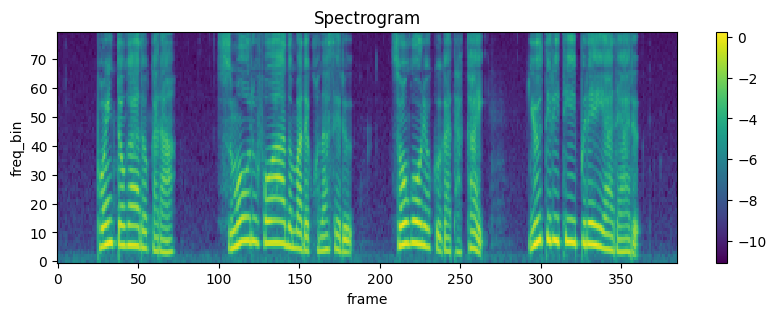

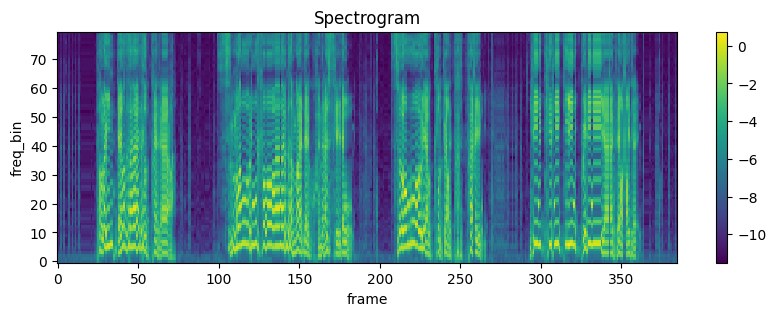

In [2]:
index = faiss.read_index(str(FAISS_DIR / "jvs001.index"))
values = np.load(KV_DIR / "jvs001_value.npy")

item = dataset[1000]
print(item.name)
audio, sr = item.audio[0].to(device), item.sr
wav2vec2 = extract_wav2vec2(audio, sr)
mel = extract_melspec(audio, sr)
keys = wav2vec2.cpu().numpy()

hat = []
for i in range(len(keys)):
  D, I = index.search(keys[None, i], 16)
  items: list[NPArray] = []
  for j in range(1):
    items.append(values[I[0][j]])
  hat.append(np.mean(np.stack(items), axis=0))
hat = torch.as_tensor(np.vstack(hat)).to(device)
audio_hat, sr_hat = vocoder(hat)
plot_spectrogram(mel)
plot_spectrogram(hat)
play_audio(audio, sr)
play_audio(audio_hat, sr_hat)

### 最も近い 2 つの音声の平均を取ってみる。

jvs/jvs007/parallel100/VOICEACTRESS100_061.wav


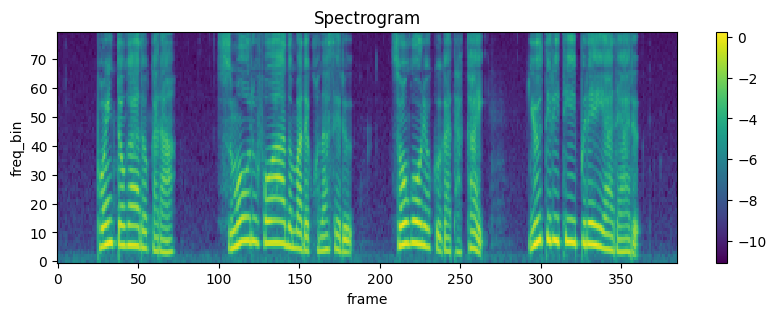

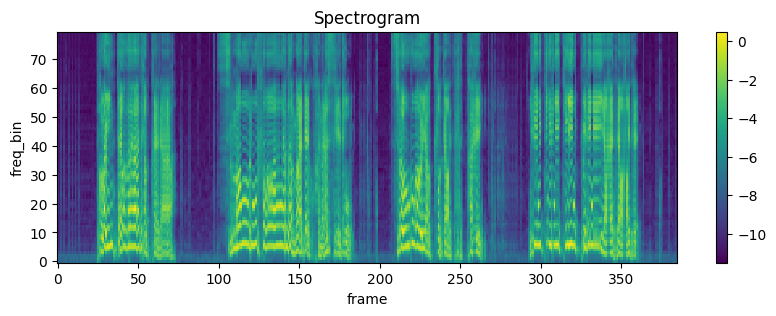

In [3]:
index = faiss.read_index(str(FAISS_DIR / "jvs001.index"))
values = np.load(KV_DIR / "jvs001_value.npy")

item = dataset[1000]
print(item.name)
audio, sr = item.audio[0].to(device), item.sr
wav2vec2 = extract_wav2vec2(audio, sr)
mel = extract_melspec(audio, sr)
keys = wav2vec2.cpu().numpy()

hat = []
for i in range(len(keys)):
  D, I = index.search(keys[None, i], 16)
  items: list[NPArray] = []
  for j in range(2):
    items.append(values[I[0][j]])
  hat.append(np.mean(np.stack(items), axis=0))
hat = torch.as_tensor(np.vstack(hat)).to(device)
audio_hat, sr_hat = vocoder(hat)
plot_spectrogram(mel)
plot_spectrogram(hat)
play_audio(audio, sr)
play_audio(audio_hat, sr_hat)

### 最も近い 4 つの音声の平均を取ってみる。

jvs/jvs007/parallel100/VOICEACTRESS100_061.wav


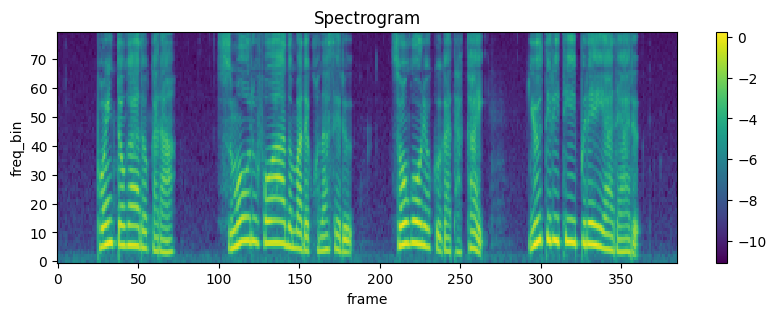

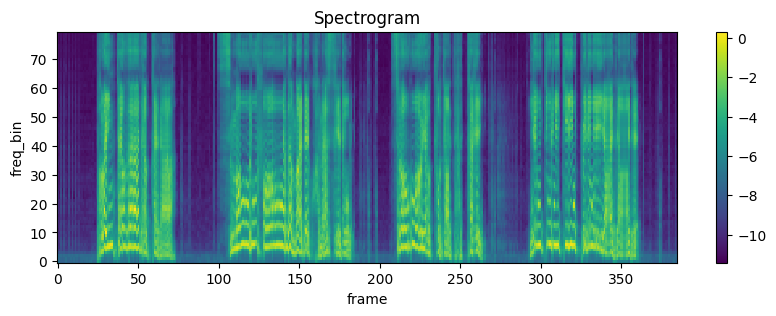

In [4]:
index = faiss.read_index(str(FAISS_DIR / "jvs001.index"))
values = np.load(KV_DIR / "jvs001_value.npy")

item = dataset[1000]
print(item.name)
audio, sr = item.audio[0].to(device), item.sr
wav2vec2 = extract_wav2vec2(audio, sr)
mel = extract_melspec(audio, sr)
keys = wav2vec2.cpu().numpy()

hat = []
for i in range(len(keys)):
  D, I = index.search(keys[None, i], 16)
  items: list[NPArray] = []
  for j in range(4):
    items.append(values[I[0][j]])
  hat.append(np.mean(np.stack(items), axis=0))
hat = torch.as_tensor(np.vstack(hat)).to(device)
audio_hat, sr_hat = vocoder(hat)
plot_spectrogram(mel)
plot_spectrogram(hat)
play_audio(audio, sr)
play_audio(audio_hat, sr_hat)

### 最も近い 16 つの音声の平均を取ってみる。

jvs/jvs007/parallel100/VOICEACTRESS100_061.wav


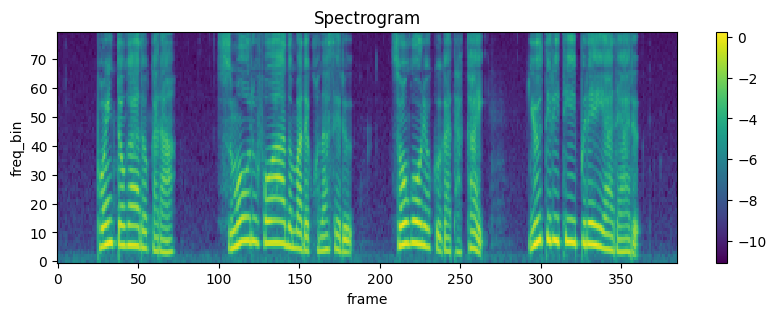

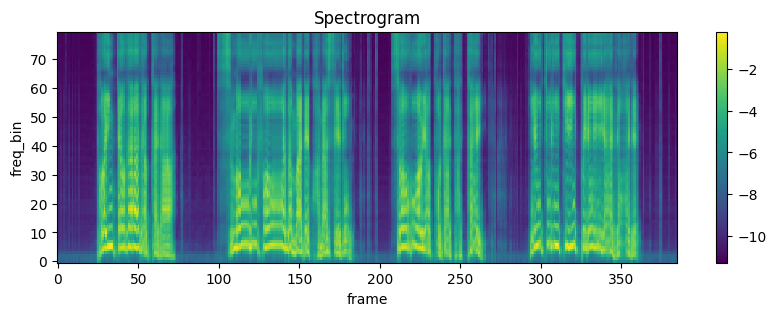

In [5]:
index = faiss.read_index(str(FAISS_DIR / "jvs001.index"))
values = np.load(KV_DIR / "jvs001_value.npy")

item = dataset[1000]
print(item.name)
audio, sr = item.audio[0].to(device), item.sr
wav2vec2 = extract_wav2vec2(audio, sr)
mel = extract_melspec(audio, sr)
keys = wav2vec2.cpu().numpy()

hat = []
for i in range(len(keys)):
  D, I = index.search(keys[None, i], 16)
  items: list[NPArray] = []
  for j in range(16):
    items.append(values[I[0][j]])
  hat.append(np.mean(np.stack(items), axis=0))
hat = torch.as_tensor(np.vstack(hat)).to(device)
audio_hat, sr_hat = vocoder(hat)
plot_spectrogram(mel)
plot_spectrogram(hat)
play_audio(audio, sr)
play_audio(audio_hat, sr_hat)